In [1]:
# Import necessary libraries
import sys
import random
import torch
import os
import math
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set path to fix relative imports
sys.path.append("..")
from data import TimeFusionDataset
from timefusion import TimeFusion, EarlyStopper
from metrics import variogram_score, crps_sum

In [2]:
# Import dataset
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

# Standardize data
means = train_data.mean()
stds = train_data.std()
train_data = (train_data-means)/stds
test_data = (test_data-means)/stds

# Randomly remove 30% of data to make irregular
np.random.seed(0) # Set random seed to make result reproducible
#remove = 0.30
remove = 0

# Training data 
train_mask = np.full(train_data.size, False)
train_mask[:int(train_data.size*remove)] = True
np.random.shuffle(train_mask)
train_data = train_data.mask(train_mask.reshape(train_data.shape))

# Test data
test_mask = np.full(test_data.size, False)
test_mask[:int(test_data.size*remove)] = True
np.random.shuffle(test_mask)
test_data = test_data.mask(test_mask.reshape(test_data.shape))

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")
    #device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
# Define some common variables
context_length = 48 
prediction_length = 1

encodings = [
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*7)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*30)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*90)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*365)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*7)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*30)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*90)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*365)),
]

# Create each dataset
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
    pin_memory=True,
    pin_memory_device="cuda:0"
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
    pin_memory=True,
    pin_memory_device="cuda:0"
)



In [5]:
predictor = TimeFusion(
    context_length = context_length,
    prediction_length = prediction_length,
    timeseries_shape = (len(train_dataset.time_series),train_dataset.time_series[0].shape[1]), 
    num_encoder_layers=3,
    d_model=512,
    nhead=32,
    dim_feedforward=1024,
    diff_steps=100,
    device = device,
)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/visualisation_notebooks/../diffusion.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [6]:
# Load weights
predictor.load_state_dict(torch.load("../training_scripts/weights/2023-04-17-20-04-23",map_location=torch.device('cpu')))
predictor.eval()
#predictor.load_state_dict(torch.load("../weights/2023-04-12-20-02-45",map_location=torch.device('cpu')).state_dict())

TimeFusion(
  (embedding): Linear(in_features=60, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features

In [7]:
sample_index = 100

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
    prediction_length = 24,
    timestamp_encodings = encodings
)

timestamps = []
for col in range(test_dataset.indices.shape[1]):
    timestamps.append(list(test_data.iloc[sample_index:,col].dropna().index[:24]))

timestamps = np.array(timestamps)

samples = predictor.sample(
    data = test_dataset,
    sample_indices = timestamps,
    num_samples = 100,
    timestamp_encodings = encodings,
    prediction_length=24
)


In [8]:
realisations = []
for col in range(test_dataset.indices.shape[1]):
    realisations.append(test_dataset.data_copy.iloc[sample_index:,col].dropna()[:test_dataset.prediction_length])
realisations = np.array(realisations)

predictions = np.array(samples.cpu()[:,:,-test_dataset.prediction_length:,0])

# Calculate metrics
var_score = variogram_score(realisations,predictions,**{"weights":"local","window_size":5})
crps_score = crps_sum(realisations,predictions)

print(var_score,crps_score)

2432.5963909134903 3.805052112996646


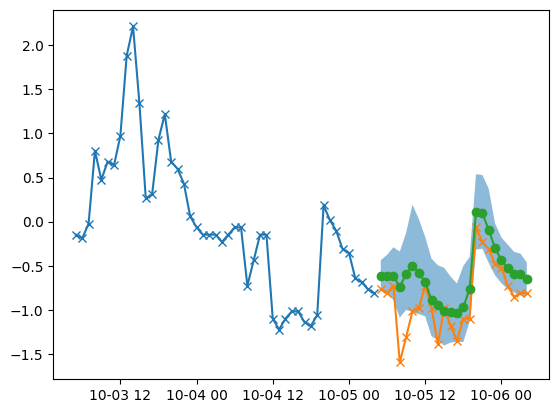

In [15]:
# Plot the samples
confidence = 0.1
ts = 9

samples_cpu = predictions.copy()
for i in range(samples_cpu.shape[1]):
    samples_cpu[:,i,:] = np.sort(samples_cpu[:,i,:],axis=0)

plt.figure()
plt.plot(test_data.iloc[:sample_index,ts].dropna().iloc[-test_dataset.context_length:],"-x")
plt.plot(test_data.iloc[sample_index:,ts].dropna().iloc[:test_dataset.prediction_length],"-x")
plt.fill_between(timestamps[ts], samples_cpu[int(confidence*samples_cpu.shape[0]),ts,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),ts,:],alpha=0.5)
plt.plot(timestamps[ts],np.mean(samples_cpu,axis=0)[ts],"-o")

In [10]:
predictions = np.array(samples.cpu()[:,:,-test_dataset.prediction_length:,0])

# Calculate metrics
var_score = variogram_score(realisations,predictions,**{"weights":"local","window_size":5})
crps_score = crps_sum(realisations,predictions)

print(var_score,crps_score)

2432.5963909134903 3.805052112996646


In [11]:
max(predictions.flatten())

3.7701418

In [12]:
min(np.sum(realisations, axis = 0).flatten())

-25.784990483497495

In [13]:
from metrics import crps
F = np.sum(predictions, axis=1)
x = np.sum(realisations, axis = 0)

[crps4(F[:,i],x[i]) for i in range(len(x))]

NameError: name 'crps4' is not defined

In [ ]:
x

array([-10.98377411, -15.99789235, -19.92270594, -19.80369452,
       -19.5649524 , -19.07673819, -14.90520671, -20.06868685,
        -7.29547497,  -1.82249595,   0.48053919,   1.7387279 ,
        -0.75262966,  -3.27557024,   0.50464866,  -4.91433771,
        -0.60914137,  -4.29616027,   6.19119665,  33.49415688,
        26.02847183,  14.39675451,   5.75728188,  -0.98399403])

In [ ]:
F[:,0]

array([ -6.8018756,  -9.944068 , -13.5296955,  -8.07407  , -10.231333 ,
        -9.218697 ,  -8.211424 ,  -9.9158   , -10.82117  , -10.615027 ,
        -8.266022 , -10.4813   ,  -9.644702 , -11.811579 , -11.212442 ,
        -9.806957 ,  -6.808426 ,  -9.469788 , -11.174243 , -12.054051 ,
       -10.928341 ,  -8.839846 , -10.528134 , -11.624802 ,  -9.740789 ,
        -8.901914 , -12.08709  ,  -9.66725  , -11.869783 ,  -8.954688 ,
       -11.573448 ,  -7.2043886, -10.530111 , -10.740392 , -10.0266695,
        -9.723686 ,  -8.563846 ,  -9.403668 , -10.072677 ,  -9.469351 ,
       -12.47757  ,  -9.441109 ,  -9.492145 , -11.63578  ,  -9.044448 ,
        -8.935162 , -10.034    ,  -7.358909 ,  -9.959104 ,  -9.8475065,
        -8.78539  ,  -8.872412 ,  -9.234541 ,  -7.347124 , -10.80336  ,
        -7.1117373, -10.530499 ,  -9.300917 ,  -8.8633585, -11.261789 ,
        -8.990646 ,  -9.825609 ,  -9.524042 , -10.711633 ,  -8.516817 ,
        -9.556381 , -11.170796 , -10.401517 ,  -9.22149  ,  -8.3

In [ ]:
from scipy.stats import percentileofscore

percentileofscore(F[:,0],-10,kind="weak")/100

0.42

In [ ]:
import scipy.integrate as integrate

def lam3(q,y,alpha):
    return (alpha - np.heaviside(q-y,0.5))*(y-q)

def crps4(F: np.ndarray, x: float) -> float:
    """
        F: [num samples]
    """
    integral_values = integrate.quad(lambda alpha: 2*lam3(np.quantile(F,alpha),x,alpha) , 0, 1,epsrel=1.49e-2,limit=100)

    #return integral_values[0]
    return 0.01*sum([2*lam3(np.quantile(F,alpha),x,alpha) for alpha in np.linspace(0,1,100)])

def crps_sum3(realisations: np.ndarray, predictions: np.ndarray) -> float:
    """
        https://arxiv.org/pdf/1910.03002.pdf
        realisations: [num timeseries, num timesteps]
        predictions: [num samples, num timeseries, num timesteps]
    """
    F = np.sum(predictions, axis=1)
    x = np.sum(realisations, axis = 0)

    return np.mean([crps(F[:,i],x[i]) for i in range(len(x))])

In [ ]:
import numpy as np
from scipy.integrate import quad

def crps(observed, forecast):
    """Calculate the continuous ranked probability score (CRPS).

    Parameters
    ----------
    observed : float or numpy.ndarray
        The observed value(s).
    forecast : float or numpy.ndarray
        The forecasted cumulative distribution function (CDF) value(s).

    Returns
    -------
    float
        The CRPS value.

    """
    def integrand(t):
        return (np.interp(t, forecast, forecast, left=0, right=1) - 
                np.heaviside(t - observed, 0.5)) ** 2

    return quad(integrand, -np.inf, np.inf)[0]

def crps_sum(observed, forecast):
    """Calculate the CRPS-sum metric.

    Parameters
    ----------
    observed : numpy.ndarray
        An array of observed values.
    forecast : numpy.ndarray
        An array of forecasted CDF values.

    Returns
    -------
    float
        The CRPS-sum value.

    """
    n = len(observed)
    crps_values = np.zeros(n)
    for i in range(n):
        crps_values[i] = crps(observed[i], forecast[i])
    return crps_values.sum() / n


In [ ]:
# Example usage
observed = np.array([2, 4, 6, 8, 10])
forecast = np.array([[0.1, 0.3, 0.5, 0.7, 0.9],
                     [0.2, 0.4, 0.6, 0.8, 0.9],
                     [0.1, 0.4, 0.5, 0.7, 0.8],
                     [0.3, 0.4, 0.6, 0.8, 0.9],
                     [0.2, 0.3, 0.5, 0.7, 0.8]])
crps_sum_value = crps_sum(observed, forecast)
print(crps_sum_value)


5.351066439849451


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_46409/2414179191.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, -np.inf, np.inf)[0]


In [ ]:
np.heaviside(-10 + 10, 1)

1.0

In [ ]:
samples.cpu()[:,4,predictor.context_length,0]

tensor([-0.8367, -0.7199, -0.7012, -0.6597, -0.6480, -0.6292, -0.6206, -0.6085,
        -0.5900, -0.5672, -0.5636, -0.5580, -0.5260, -0.5255, -0.5207, -0.5187,
        -0.4867, -0.4791, -0.4739, -0.4731, -0.4713, -0.4634, -0.4622, -0.4551,
        -0.4393, -0.4191, -0.4184, -0.4122, -0.3978, -0.3932, -0.3776, -0.3772,
        -0.3749, -0.3712, -0.3607, -0.3550, -0.3480, -0.3430, -0.3161, -0.3153,
        -0.3054, -0.3041, -0.2699, -0.2653, -0.2574, -0.2566, -0.2547, -0.2464,
        -0.2342, -0.2311, -0.2248, -0.2202, -0.2193, -0.2184, -0.2144, -0.1980,
        -0.1968, -0.1905, -0.1892, -0.1889, -0.1862, -0.1857, -0.1853, -0.1497,
        -0.1320, -0.1283, -0.1269, -0.1246, -0.1167, -0.1124, -0.1072, -0.0976,
        -0.0719, -0.0711, -0.0698, -0.0514, -0.0497, -0.0497, -0.0461, -0.0352,
        -0.0331, -0.0197, -0.0161, -0.0089, -0.0081,  0.0015,  0.0048,  0.0167,
         0.0212,  0.0264,  0.0352,  0.0369,  0.0410,  0.0745,  0.0768,  0.0860,
         0.1644,  0.1916,  0.1992,  0.33